In [2]:
from concurrent.futures import ThreadPoolExecutor


from utils import predict_xra # needed to change predict xr to predict xra for some reason - check why - 
import geopandas as gpd
import numpy as np
import odc.geo  # noqa: F401
# from dea_tools.classification import predict_xr
from odc.stac import load
from pystac_client import Client
from shapely import geometry
from sklearn.ensemble import RandomForestClassifier

%load_ext autoreload
%autoreload 2

# from model import add_image_values, get_model_prediction, get_overlay



In [3]:
fiji_bbox = [177.2, -18.4, 178.9, -17.2]
fiji_bbox_geometry = geometry.box(*fiji_bbox)
fiji_bbox_geometry

# training_file = "training_data/lulc_bare_land.geojson"
training_file = "training_data/training_data.geojson"


In [4]:
# Explore training data
tdata = gpd.read_file(training_file, bbox=fiji_bbox_geometry)
tdata.explore()

In [5]:
print(len(tdata))

834


In [6]:
# Check that reindexing is valid / uniquely valued index values
print(tdata.index.is_unique)  # 👉️ False

True


In [7]:
collection = "dep_s2_geomad"

client = Client.open("https://stac.staging.digitalearthpacific.org")

items = list(client.search(
    collections=[collection],
    bbox=fiji_bbox,
    datetime="2023"
).items())

print(f"Found {len(items)} items")

Found 6 items


## Note to future Nick

Wait for Alex to produce S-2 GeoMAD, then do the real work with that.

Between now and then, experiment with doing another LOAD step, like we're doing here, but with S-1.

So do the following:

* Search the MSPC STAC API for S-1 Items over our BBOX area over the year of interest
* Load them using odc.stac.load and do an annual summary, probably using a mean over time
* Maybe compute stdev too
* then add a HH/HV too, so you'll have a single timestep with HH_Mean, HV_Mean, HH_StdDev, HV_StdDev and HH/HV
* That can be added to the below data from GeoMAD.

Hint, when you use `load`, you can pass in the existin data. So first load GeoMad, then get `load(items, geobox=data.geobox)` 


In [8]:
bands = [
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B08",
    "B8A",
    "B11",
    "B12",
    "emad",
    "bcmad",
    "smad",
]

data = load(
    items,
    measurements=bands,
    resolution=10,
    chunks={"x": 100, "y": 100, "time": 1},
)

data = data.squeeze("time")

data

<xarray.Dataset>
Dimensions:      (y: 19200, x: 28800)
Coordinates:
  * y            (y) float64 -1.888e+06 -1.888e+06 ... -2.08e+06 -2.08e+06
  * x            (x) float64 2.952e+06 2.952e+06 2.952e+06 ... 3.24e+06 3.24e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2023-01-01
Data variables: (12/13)
    B02          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B03          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B04          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B05          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B06          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B07          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ...           ...
    B8A          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B11          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B12          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    emad         (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    bcmad        (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    smad         (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>

In [9]:
# Get S-1 dependencies

from planetary_computer import sign_url
import os

In [10]:
# Get the URL for STAC API on MSPC
catalogue_s1 = "https://planetarycomputer.microsoft.com/api/stac/v1/"

collection_s1 = "sentinel-1-rtc"

client_s1 = Client.open(catalogue_s1)

In [11]:
# Search for datasets

fiji_bbox = [177.2, -18.4, 178.9, -17.2]

datetime = "2023"


In [12]:
# Get a pystac client for the MSPC
items_s1 = list(client_s1.search(collections=[collection_s1], bbox=fiji_bbox, datetime=datetime).items())
print(len(items_s1))

133


In [13]:
# Authorised access to MPC data
os.environ["PC_SDK_SUBSCRIPTION_KEY"] = "84162f5502174b1b838239e74a44898d"

In [14]:
# Load data

data_s1 = load(items_s1, chunks={}, groupby="solar_day", like=data, patch_url=sign_url)

data_s1 = data_s1.where(data_s1 != -32768)

data_s1

<xarray.Dataset>
Dimensions:      (time: 107, y: 19200, x: 28800)
Coordinates:
  * y            (y) float64 -1.888e+06 -1.888e+06 ... -2.08e+06 -2.08e+06
  * x            (x) float64 2.952e+06 2.952e+06 2.952e+06 ... 3.24e+06 3.24e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2023-01-01T06:40:42.198354 ... 2023-12...
Data variables:
    vh           (time, y, x) float32 dask.array<chunksize=(1, 19200, 28800), meta=np.ndarray>
    vv           (time, y, x) float32 dask.array<chunksize=(1, 19200, 28800), meta=np.ndarray>

In [15]:
# Load data using the existing geomad geobox


In [16]:
# Create means over time
mean_s1 = data_s1.mean(dim="time")
mean_s1["vv_vh"] = mean_s1.vv/mean_s1.vh
mean_s1


<xarray.Dataset>
Dimensions:      (y: 19200, x: 28800)
Coordinates:
  * y            (y) float64 -1.888e+06 -1.888e+06 ... -2.08e+06 -2.08e+06
  * x            (x) float64 2.952e+06 2.952e+06 2.952e+06 ... 3.24e+06 3.24e+06
    spatial_ref  int32 3832
Data variables:
    vh           (y, x) float32 dask.array<chunksize=(19200, 28800), meta=np.ndarray>
    vv           (y, x) float32 dask.array<chunksize=(19200, 28800), meta=np.ndarray>
    vv_vh        (y, x) float32 dask.array<chunksize=(19200, 28800), meta=np.ndarray>

In [17]:
# Plot s1
# mean_s1.vv_vh.plot.imshow(size=8, robust=True)

In [18]:
# Merge datasets

merged = data.update(mean_s1)#.compute()
merged

<xarray.Dataset>
Dimensions:      (y: 19200, x: 28800)
Coordinates:
  * y            (y) float64 -1.888e+06 -1.888e+06 ... -2.08e+06 -2.08e+06
  * x            (x) float64 2.952e+06 2.952e+06 2.952e+06 ... 3.24e+06 3.24e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2023-01-01
Data variables: (12/16)
    B02          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B03          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B04          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B05          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B06          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B07          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ...           ...
    emad         (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    bcmad        (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    smad         (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    vh           (y, x) float32 dask.array<chunksize=(19200, 28800), meta=np.ndarray>
    vv           (y, x) float32 dask.array<chunksize=(19200, 28800), meta=np.ndarray>
    vv_vh        (y, x) float32 dask.array<chunksize=(19200, 28800), meta=np.ndarray>

In [19]:
tdata

,index,id,x,y,lulc_code,lulc_class,geometry
0,0,1,178.49336389086915,-17.630350557703498,1,bare_land,POINT (178.49336 -17.63035)
1,1,2,178.49300153840352,-17.630246702625392,1,bare_land,POINT (178.49300 -17.63025)
2,2,3,178.49233950865994,-17.630545461057412,1,bare_land,POINT (178.49234 -17.63055)
3,3,4,178.49202514878587,-17.63155912685818,1,bare_land,POINT (178.49203 -17.63156)
4,4,5,178.49283688193435,-17.630265812783897,1,bare_land,POINT (178.49284 -17.63027)
...,...,...,...,...,...,...,...
829,987,988,178.5476143232446,-18.10723016786599,7,water,POINT (178.54761 -18.10723)
830,988,989,178.50962438386574,-17.609866703693093,7,water,POINT (178.50962 -17.60987)
831,989,990,178.49982975352953,-17.62165421958133,7,water,POINT (178.49983 -17.62165)
832,990,991,178.16260760168362,-18.221356378366945,7,water,POINT (178.16261 -18.22136)


In [ ]:
projected_training_data = tdata.to_crs("EPSG:3832")
training_array = []

def get_training_data(id_row):
    _, row = id_row
    cls = row["lulc_class"]
    # Add more classes as integers here.
    # Maybe use a look-up table.
    # cls_id = 1 if cls == "bare_land" else 0

# Classes defined within dictionary
   
    lookup = {
        "bare_land": 1,
        "forest": 2,
        "crops": 3,
        "grassland": 4,
        "settlements": 5,
        "mangroves": 6,
        "water": 7,
    }
    
    # lookup = {(
    #     ["bare_land", 1, '#919191'],
    #     ["forest", 2, '#064a00'],
    #     ["crops", 3, '#b67e00'],
    #     ["grassland", 4, '#d7ffa0'],
    #     ["settlements", 5, '#bd0007'],
    #     ["mangroves", 6, '#73ffd2'],
    #     ["water", 7,'#71a8ff'], columns=['lulc_class', 'lulc_code', 'color']).set_index('lulc_code')
    # }

    id = row["id"]
    geom = row["geometry"]
    
# Get the class, and default to 0 if it's not in the lookup table
    cls_id = lookup.get(cls, 0)

    row = id_row

    # Get xarray values at the point
    x = merged.sel(x=geom.x, y=geom.y, method="nearest")#.compute()
    one_point = [id] + [cls_id] + [float(v) for v in x.values()]
    return one_point

with ThreadPoolExecutor(max_workers=10) as executor:
    training_array = list(executor.map(get_training_data, projected_training_data.iterrows()))

print(f"Fetched data for {len(training_array)} training points")

In [ ]:
classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=10,
    n_jobs=-1,
    random_state=42,
)

training_data = np.array(training_array)[:, 2:]
classes = np.array(training_array)[:, 1]

model = classifier.fit(training_data, classes)

In [ ]:
# This is for a small subset region
# ll = -17.82845, 177.30492
# ur = -17.49281, 177.77527
# predict_data = load(items, bbox=(ll[1], ll[0], ur[1], ur[0]), measurements=bands, chunks={})

# This one loads all the data from all Viti Levu
# predict_data = load(items, bbox=fiji_bbox, measurements=bands, chunks={})

# predict_data = predict_data.compute()
predict_data = merged
# predict_data = predict_data.squeeze("time")
predict_data = predict_data.fillna(-9999)
predict_data

In [ ]:
from utils import predict_xra


In [ ]:
tdata.info

In [ ]:
tdata.describe

In [ ]:
# This runs the actual prediction
predicted = predict_xra(model, predict_data, proba=True)

In [ ]:
# Convert to int
cleaned_predictions = predicted.copy(deep=True)
cleaned_predictions.predictions.data = predicted.predictions.data.astype(np.int8)
cleaned_predictions.probabilities.data = predicted.probabilities.data.astype(np.float32)

cleaned_predictions = cleaned_predictions.rename({"predictions": "lulc", "probabilities": "prob"})

cleaned_predictions.prob.plot.imshow(size=10)

In [ ]:
cleaned_predictions.lulc.plot.imshow(size=10, cmap="ocean") # https://matplotlib.org/stable/users/explain/colors/colormaps.html

In [ ]:
# explore(cleaned_predictions)

In [ ]:
# overlay = get_overlay(cleaned_predictions, cmap)
# center = [20,-180]
# zoom = 18
# m = Map(basemap=basemaps.Esri.WorldImagery, center=center, zoom=zoom, interpolation="nearest", scroll_wheel_zoom=True)
# control = LayersControl(position='topright')
# m.add_control(control)
# m.add(overlay)
# m.layout.width = '80%'
# m.layout.height = '500px'
# m.fit_bounds(overlay.bounds)
# m

In [ ]:
# Write GeoTIFF
cleaned_predictions.prob.odc.write_cog("prob_fiji.tif", overwrite=True)

In [ ]:
merged


In [ ]:
nir = merged.B05
red = merged.B04

In [ ]:
ndvi = (nir - red)/(nir + red)

In [ ]:
ndvi.plot.imshow(size=10, vmin=-1, vmax=1, cmap='RdYlGn')

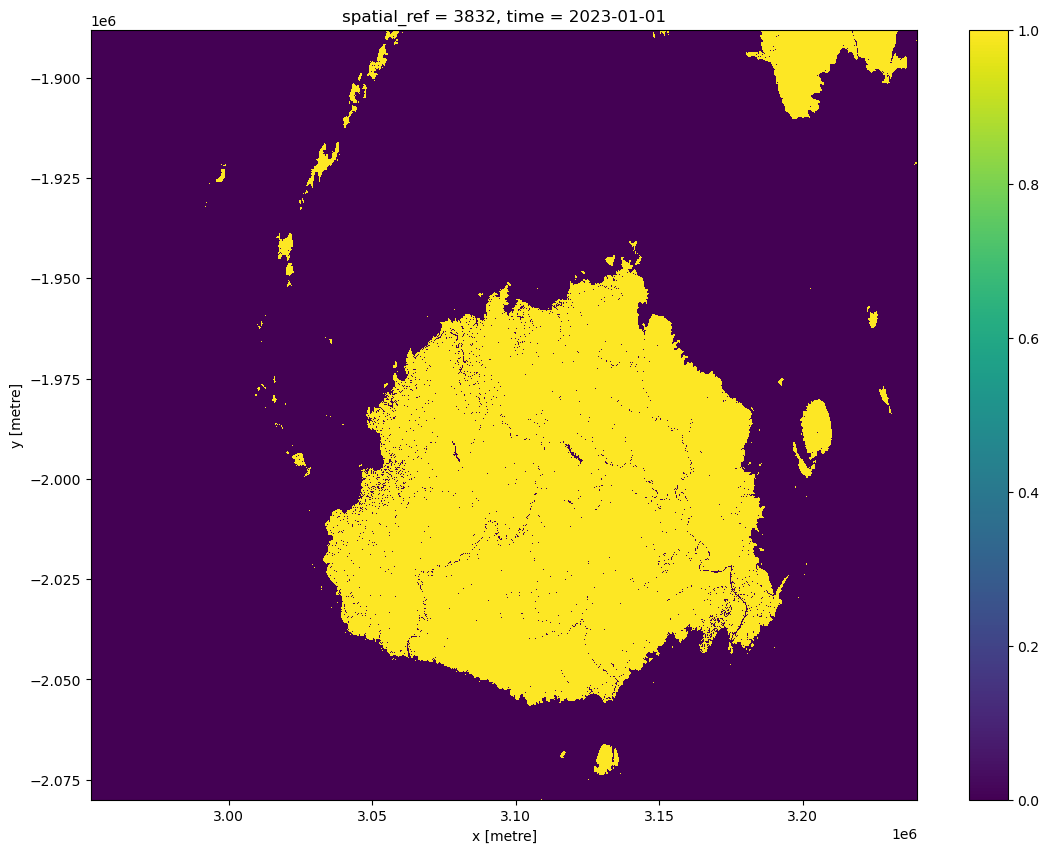

In [41]:
ndvi_mask = (ndvi>0.1)
ndvi_mask.plot.imshow(size=10)

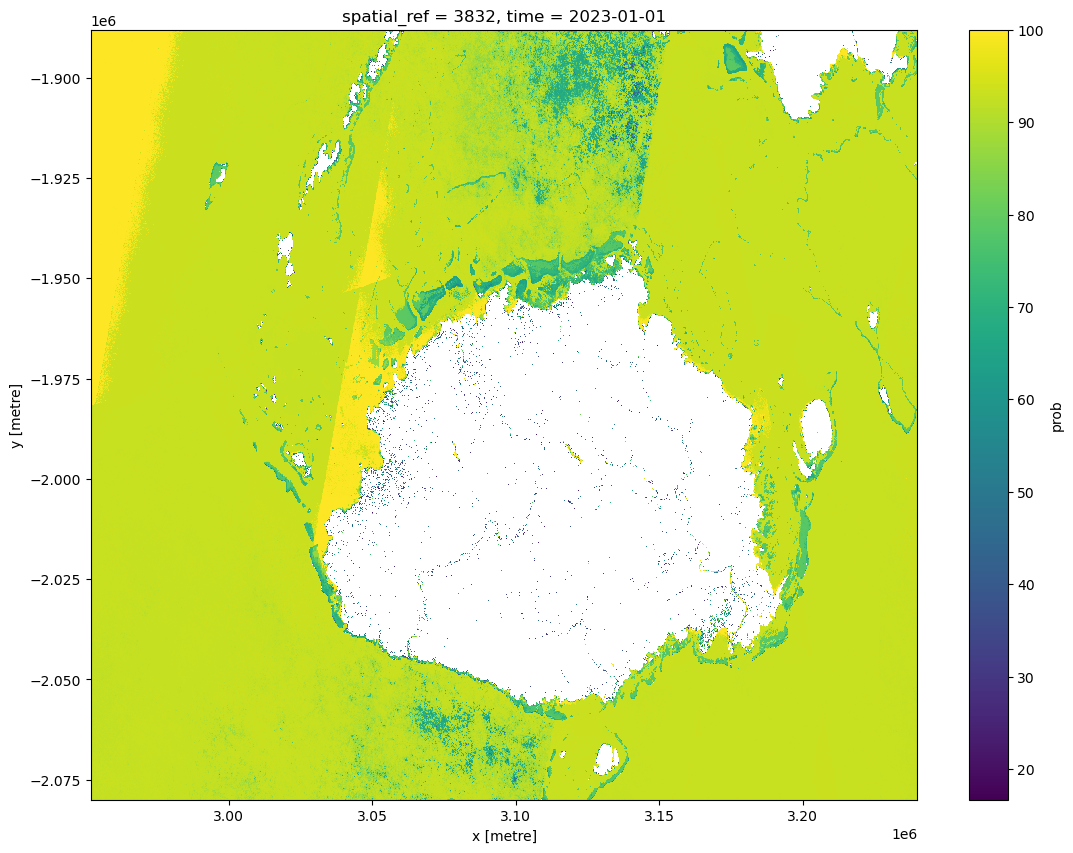

In [42]:
masked_predictions = cleaned_predictions.where(~ndvi_mask)
masked_predictions.prob.plot.imshow(size=10)